Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 13.73                             
Matching: model call n. 13 penalty = 3.3521e-06              
Optimize - end penalty:  3.35215e-06                            


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=-0.00596372923757783


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Failed for delta0=0.00596372923757783


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

(np.float64(-48.086476220018376),
 np.float64(46.09127206002074),
 np.float64(-44.27803773469896),
 np.float64(46.22907056281693))

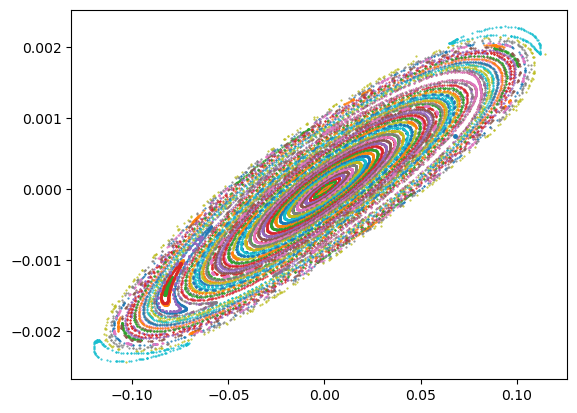

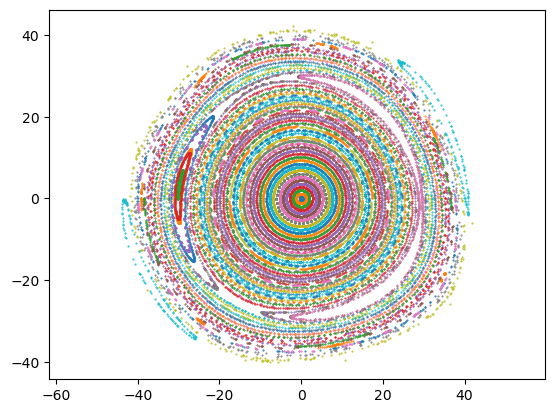

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import scipy.constants as sc


# # Functions

# In[2]:


def generate_delta_sampling(delta_min, delta_max, step=None, num_points=None):
    if step is None and num_points is None:
        raise ValueError("Either 'step' or 'num_points' must be provided.")
    if step is None:
        step = (delta_max - delta_min) / num_points

    i_min = int(np.ceil(delta_min / step))
    i_max = int(np.floor(delta_max / step))

    arr = step * np.arange(i_min, i_max + 1)
    return arr


# In[3]:


def twiss_scan(line, delta_min, delta_max, step=None, num_points=None):
    delta_values = generate_delta_sampling(delta_min, delta_max, step, num_points)

    idx_zero = np.where(delta_values == 0)[0][0]
    tw0 = line.twiss4d(delta0=0.0)
    twisses = []
    # twiss_pos.append(tw0)
    # twiss_neg.append(tw0)

    for delta in delta_values[:idx_zero][::-1]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co) if len(twisses)>0 else tw0)
    twisses = twisses[::-1]
    twisses.append(tw0)
    for delta in delta_values[idx_zero + 1:]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co))

    return delta_values, twisses


# # Line

# In[4]:


line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

# remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

on_sextupole = 1
on_octupole = 1
on_decapole = 1
on_dodecapole = 1

for nn in mba:
    env[nn].knl = np.array([0., 0.,
                            on_sextupole * 2.12e-3,
                            0.,
                            on_decapole * -5.74,
                            on_dodecapole * 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0.,
                            on_sextupole * -3.19e-3,
                            0.,
                            on_decapole * -5.10,
                            on_dodecapole * 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0.,
                            0.,
                            on_octupole * 0.75e-1,
                            0.,
                            on_dodecapole * -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0.,
                            0.,
                            on_octupole * -2.03e-1,
                            0.,
                            on_dodecapole * 2.04e3])


env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])


# # Frederik twisses

# In[5]:


def calculate_bucket_height(line, f_RF=200.26e6, V_RF=3e6):
    # Calculate bucket height
    tw_ref = line.twiss4d()
    beta0 = line.particle_ref.beta0[0]
    E = line.particle_ref.energy0[0]
    q = line.particle_ref.q0
    h = f_RF * line.get_length() / beta0 / sc.c
    eta = tw_ref.slip_factor
    return np.sqrt(2*q*V_RF / (np.pi*h*abs(eta)*E*beta0**2))

def get_twisses(line, bucket_height):
    # Perform a bunch of twisses for different delta0
    tw = {}
    beam_sizes = {}
    nemitt = 2e-6
    for delta in np.linspace(-2*bucket_height, 2*bucket_height, 101):
        this_delta = delta
        try:
            tw[this_delta] = line.twiss4d(delta0=delta)
            beam_sizes[this_delta] = tw[this_delta].get_beam_covariance(nemitt_x=nemitt, nemitt_y=nemitt)
        except:
            print(f"Failed for delta0={delta}")
            pass
    return tw, beam_sizes


# In[6]:


tw, beam_sizes = get_twisses(line, calculate_bucket_height(line, V_RF=3e6))


# In[7]:


# from make_aperture import tt_aperx
# import mplcursors


# # Initial figure

# In[9]:


tw0 = line.twiss()


# In[10]:


figsize=(13.33, 6)
xlim = (tw0.rows['qf.60810'].s, tw0.rows['qf.61410'].s)
ylim=(-0.1,0.1)
bucket_height = calculate_bucket_height(line, V_RF=3e6)


# In[11]:

plt.close('all')

fig, ax = plt.subplots(1, figsize=figsize)
delta = list(tw.keys())
for dd in delta:
    if abs(dd) <= bucket_height + 1.e-12:
        ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, 'g-')
    else:
        ax.plot(tw[dd].s, tw[dd].x + np.sign(dd)*5*beam_sizes[dd].sigma_x, 'r-')
# line1, = ax.plot(tt_aper.s, tt_aper.aper_max_x, 'k-')
# line2, = ax.plot(tt_aper.s, tt_aper.aper_min_x, 'k-')
ax.set_xlabel('s [m]')
ax.set_ylabel('Aperture $x$ [m]')
ax.set_title(f'Betatron {5}' + r'$\sigma_x$   $\delta$ within 1 bucket (green) and 2 buckets (red)')
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)
fig.tight_layout()

plt.figure(2)
tw1 = tw[delta[82]]
tw2 = tw[delta[83]]

plt.plot(tw1.s, tw1.x, label=f'delta={delta[82]:.6f}')
plt.plot(tw2.s, tw2.x, label=f'delta={delta[83]:.6f}')

# scale = np.linspace(-0.95, 1.05, 201)
# p = xt.Particles(p0c=line.particle_ref.p0c[0],
#                  mass0=line.particle_ref.mass0,
#                  q0=line.particle_ref.q0,
#                  delta=0, #tw1.delta[0] + 1e-4,
#                  x=tw1.x[0]*scale,
#                  px=tw1.px[0]*scale)
tw0 = line.twiss4d(delta0=0.0)
# p = xt.Particles(p0c=line.particle_ref.p0c[0],
#                  mass0=line.particle_ref.mass0,
#                  q0=line.particle_ref.q0,
#                  delta=0,
#                  x=np.linspace(-0.07, 0.02, 100))
p = line.build_particles(method='4d',
    x_norm=np.linspace(-40., 40, 100), nemitt_x=2e-6, nemitt_y=2e-6)
tt_cav = line.get_table(attr=True).rows.match(element_type='Cavity')
for nn in tt_cav.name:
    line[nn].voltage = 0

line.track(p, num_turns=300, turn_by_turn_monitor=True, with_progress=1)

mon = line.record_last_track
mon_norm= tw0.get_normalized_coordinates(mon, nemitt_x=2e-6, nemitt_y=2e-6)

# print('delta = ', p.delta[0])
# print(f'x =     {p.x[0]:.6f} err = {p.x[0] - p0.x[0]}')
# print(f'px =    {p.px[0]:.6f} err = {p.px[0] - p0.px[0]}')
plt.close('all')
plt.figure(3)
plt.plot(mon.x.T, mon.px.T, '.', markersize=1)
plt.plot(tw1.x[0], tw1.px[0], '.', markersize=5)

plt.figure(4)
plt.plot(mon_norm.x_norm.T, mon_norm.px_norm.T, '.', markersize=1)
plt.axis('equal')

In [4]:
mon_norm.x_norm.shape

(100, 300)

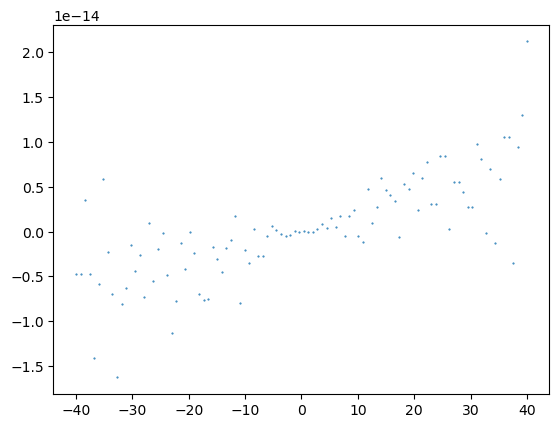

In [14]:
plt.figure()
plt.plot(
    mon_norm.x_norm[:, 0], 
    mon_norm.px_norm[:, 0], 
    marker='.', 
    markersize=1, 
    linestyle='None'
)
plt.show()

(np.float64(-46.01292096561282),
 np.float64(45.99253133362048),
 np.float64(-44.27803773469896),
 np.float64(46.22907056281693))

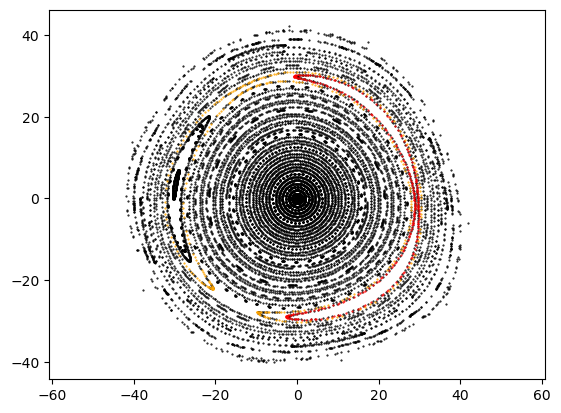

In [26]:
plt.figure(4)
plt.plot(mon_norm.x_norm.T[:, ::2], mon_norm.px_norm.T[:, ::2], '.', markersize=1, color='black')
plt.plot(mon_norm.x_norm.T[:, 85], mon_norm.px_norm.T[:, 85], '.', markersize=1, color='red')
plt.plot(mon_norm.x_norm.T[:, 87], mon_norm.px_norm.T[:, 87], '.', markersize=1, color='orange')
plt.axis('equal')

In [44]:
delta_vals = []
mon_res = []
mon_res_norm = []

r = np.linspace(-40., 40, 100)
phi = np.linspace(0, 2*np.pi, 100, endpoint=False)
r, phi = np.meshgrid(r, phi)
x_norm = r.flatten() * np.cos(phi.flatten())
px_norm = r.flatten() * np.sin(phi.flatten())
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads=12))
for delta_val in [0.0, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3]:
    tw0 = line.twiss4d(delta0=delta_val)
    p = line.build_particles(method='4d',
        x_norm=x_norm, px_norm=px_norm, nemitt_x=2e-6, nemitt_y=2e-6, delta=delta_val)

    line.track(p, num_turns=300, turn_by_turn_monitor=True, with_progress=1)

    mon = line.record_last_track
    mon_norm= tw0.get_normalized_coordinates(mon, nemitt_x=2e-6, nemitt_y=2e-6)

    delta_vals.append(delta_val)
    mon_res.append(mon)
    mon_res_norm.append(mon_norm)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

/Users/lisepauwels/Xsuite/xtrack/xtrack/twiss.py:4005: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

In [61]:
import matplotlib as mpl

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


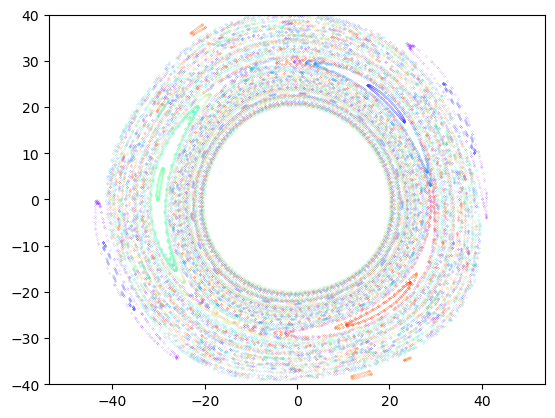

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


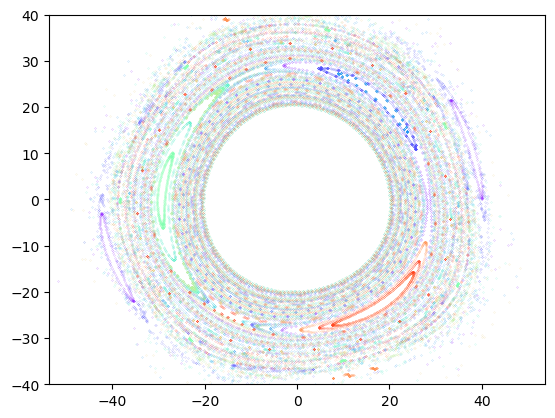

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


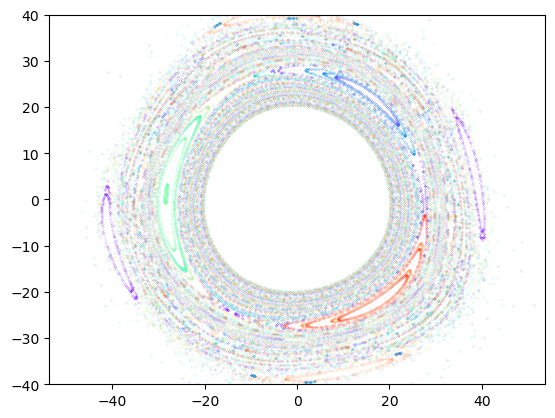

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


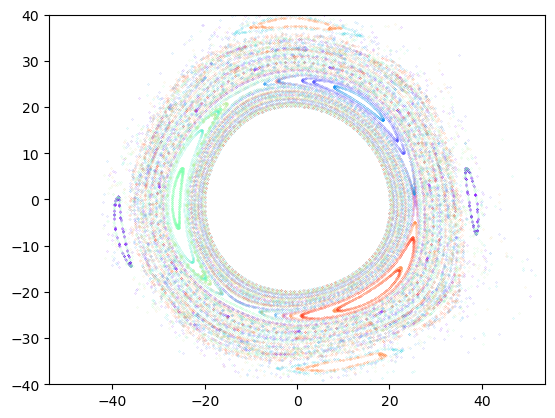

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


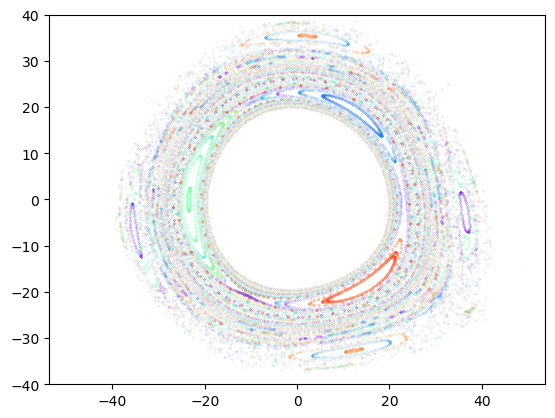

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


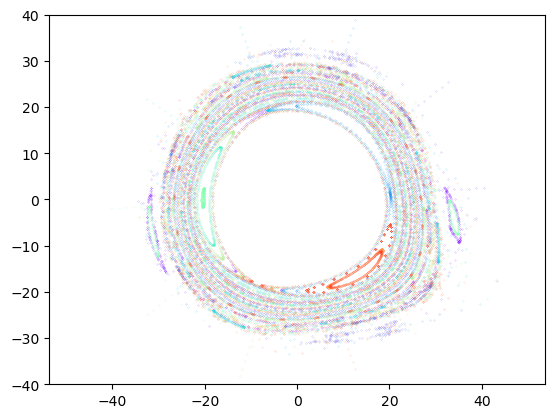

In [62]:
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, 100))

for mon_norm in mon_res_norm:
    plt.figure(4)
    for i in range(0, 100, 10):
        plt.plot(mon_norm.x_norm.T[:, i*100+75:(i+1)*100:2], mon_norm.px_norm.T[:, i*100+75:(i+1)*100:2], '.', markersize=0.2, color=colors[i])
    plt.axis('equal')
    plt.xlim((-40, 40))
    plt.ylim((-40, 40))
    plt.show()

(np.float64(-22.960034500685502),
 np.float64(1.0933349762231193),
 np.float64(0.0037800000000000034),
 np.float64(0.004220000000000004))

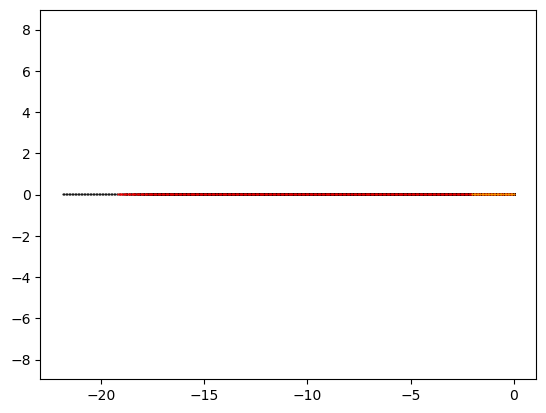

In [35]:
plt.figure(4)
plt.plot(mon_norm.zeta_norm.T[:, ::2], mon.delta.T[:, ::2], '.', markersize=1, color='black')
plt.plot(mon_norm.zeta_norm.T[:, 85], mon.delta.T[:, 85], '.', markersize=1, color='red')
plt.plot(mon_norm.zeta_norm.T[:, 87], mon.delta.T[:, 87], '.', markersize=1, color='orange')
plt.axis('equal')

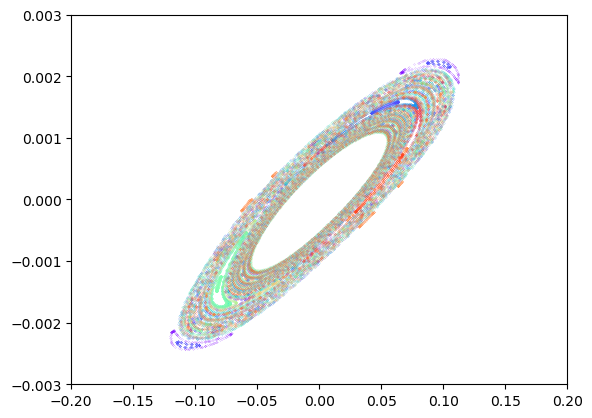

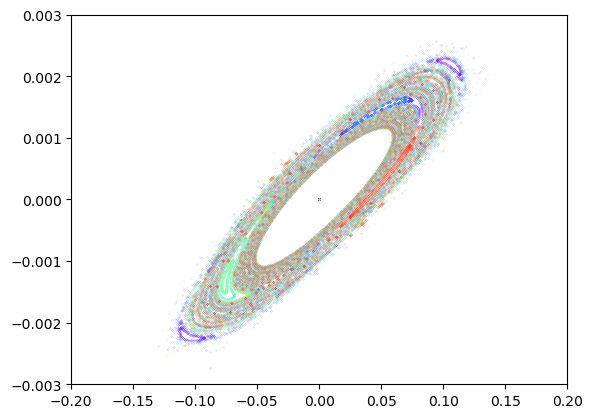

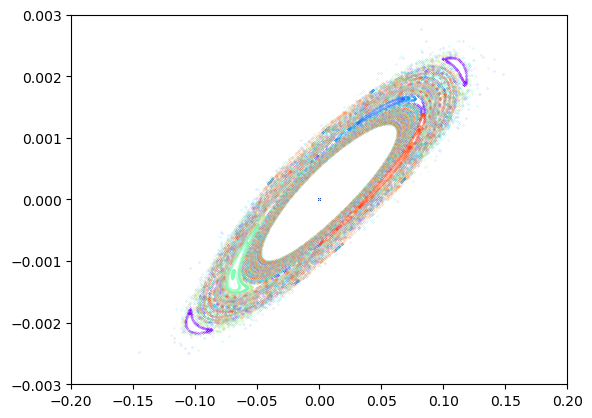

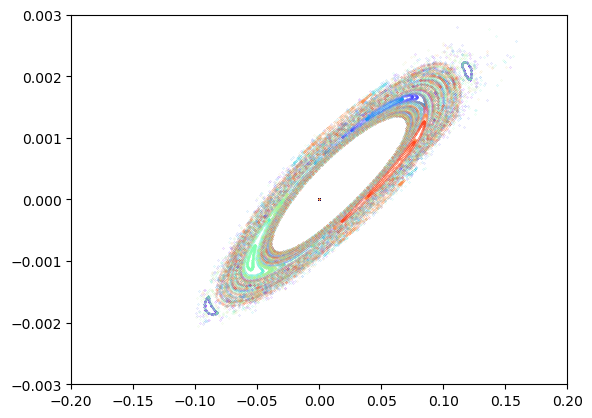

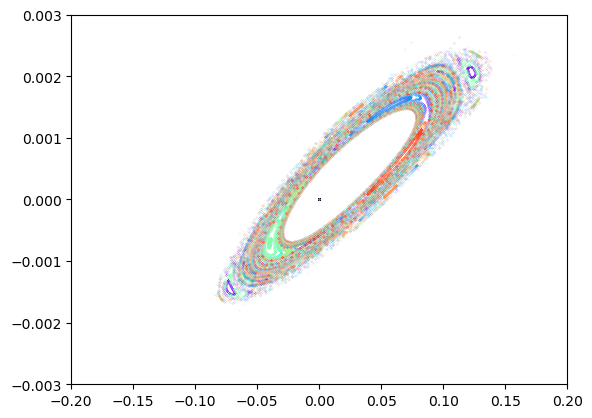

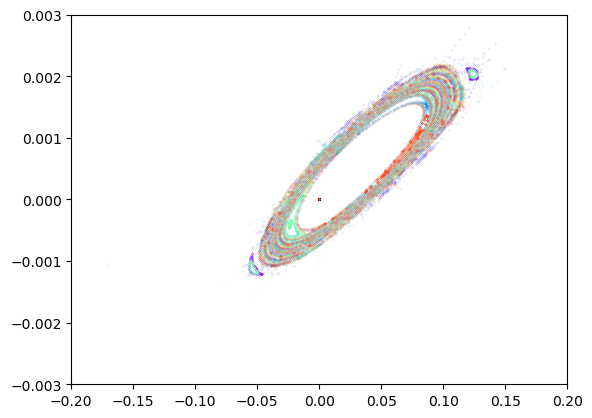

In [74]:
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, 100))

for mon in mon_res:
    plt.figure(4)
    for i in range(0, 100, 10):
        plt.plot(mon.x.T[:, i*100+75:(i+1)*100:2], mon.px.T[:, i*100+75:(i+1)*100:2], '.', markersize=0.2, color=colors[i])
    # plt.plot(mon.x.T, mon.px.T, '.', markersize=0.2)
    # plt.axis('equal')
    plt.xlim((-0.2, 0.2))
    plt.ylim((-0.003, 0.003))
    plt.show()

In [73]:
np.unique(p.state, return_counts=True)

(array([-1,  1]), array([2463, 7537]))